In [1]:
#%%
"""
Created on 08 Mar 2019
Pathwise estimation for delta and vega for the Black-Scholes model
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum

In [2]:
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

# Black-Scholes Call option price
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
    return value

def BS_Delta(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
             (T-t)) / (sigma * np.sqrt(T-t))
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1)
    elif CP == OptionType.PUT:
       value = st.norm.cdf(d1)-1
    return value

def BS_Gamma(S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
             (T-t)) / (sigma * np.sqrt(T-t))
    return st.norm.pdf(d1) / (S_0 * sigma * np.sqrt(T-t))

def BS_Vega(S_0,K,sigma,t,T,r):
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
             (T-t)) / (sigma * np.sqrt(T-t))
    return S_0*st.norm.pdf(d1)*np.sqrt(T-t)

def GeneratePathsGBMEuler(NoOfPaths,NoOfSteps,T,r,sigma,S_0):
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])

    # Approximation
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    S[:,0] =S_0

    X = np.zeros([NoOfPaths, NoOfSteps+1])
    X[:,0] =np.log(S_0)

    time = np.zeros([NoOfSteps+1])

    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]

        X[:,i+1] = X[:,i] + (r -0.5*sigma**2.0)* dt + sigma * (W[:,i+1] - W[:,i])
        time[i+1] = time[i] +dt

    # Retun S
    paths = {"time":time,"S":np.exp(X)}
    return paths

def EUOptionPriceFromMCPathsGeneralized(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K),1])
    if CP == OptionType.CALL:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(S-k,0.0))
    elif CP == OptionType.PUT:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(k-S,0.0))
    return result

def PathwiseDelta(S0,S,K,r,T):
    temp1 = S[:,-1]>K
    return np.exp(-r*T)*np.mean(S[:,-1]/S0*temp1)

def PathwiseVega(S0,S,sigma,K,r,T):
    temp1 = S[:,-1]>K
    temp2 = 1.0/sigma* S[:,-1]*(np.log(S[:,-1]/S0)-(r+0.5*sigma**2.0)*T)
    return np.exp(-r*T)*np.mean(temp1*temp2)


def mainCalculation():
    CP        = OptionType.CALL
    S0        = 1
    r         = 0.06
    sigma     = 0.3
    T         = 1
    K         = np.array([S0])
    t         = 0.0

    NoOfSteps = 1000
    delta_Exact = BS_Delta(CP,S0,K,sigma,t,T,r)
    vega_Exact  = BS_Vega(S0,K,sigma,t,T,r)

    NoOfPathsV = np.round(np.linspace(5,1000,50))
    deltaPathWiseV = np.zeros(len(NoOfPathsV))
    vegaPathWiseV  = np.zeros(len(NoOfPathsV))

    for (idx,nPaths) in enumerate(NoOfPathsV):
        #print('Running simulation with {0} paths'.format(nPaths))
        np.random.seed(3)
        paths1 = GeneratePathsGBMEuler(int(nPaths),NoOfSteps,T,r,sigma,S0)
        S = paths1["S"]
        delta_pathwise = PathwiseDelta(S0,S,K,r,T)
        deltaPathWiseV[idx]= delta_pathwise

        vega_pathwise = PathwiseVega(S0,S,sigma,K,r,T)
        vegaPathWiseV[idx] =vega_pathwise

    plt.figure(1)
    plt.grid()
    plt.plot(NoOfPathsV,deltaPathWiseV,'.-r')
    plt.plot(NoOfPathsV,delta_Exact*np.ones([len(NoOfPathsV),1]))
    plt.xlabel('number of paths')
    plt.ylabel('Delta')
    plt.title('Convergence of pathwise delta w.r.t number of paths')
    plt.legend(['pathwise est','exact'])

    plt.figure(2)
    plt.grid()
    plt.plot(NoOfPathsV,vegaPathWiseV,'.-r')
    plt.plot(NoOfPathsV,vega_Exact*np.ones([len(NoOfPathsV),1]))
    plt.xlabel('number of paths')
    plt.ylabel('Vega')
    plt.title('Convergence of pathwise vega w.r.t number of paths')
    plt.legend(['pathwise est','exact'])

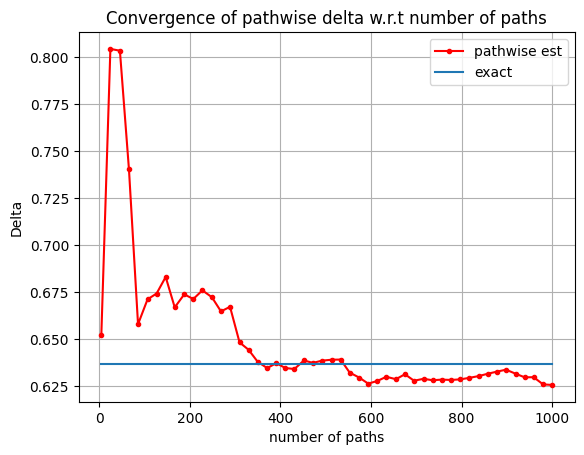

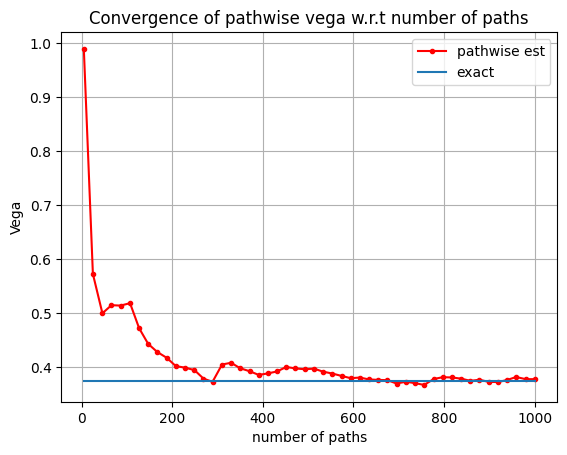

In [3]:
mainCalculation()